#Paper [12]
[Comparative Study of ML Algorithms in Diabetes Prediction.](https://www.ewadirect.com/proceedings/ace/article/view/10999)

In [2]:
# !pip install imblearn
# !pip install lime
# !pip install shap
# !pip install alibi

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular
from alibi.explainers import ALE, plot_ale

In [4]:
df = pd.read_csv('/content/preprocessed_diabetes_data.csv')

In [5]:
X=df.drop('Diabetes_012',axis=1)
y=df['Diabetes_012']

In [6]:
y.value_counts()

,count
Diabetes_012,
0.0,190055
1.0,39726


In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

,count
Diabetes_012,
0.0,190055
1.0,190055


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Grid Search by RF Model

In [10]:
param_grid = {
    'n_estimators': [18],
    'max_depth': [8],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_samples': [0.8]
    }

In [11]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [8], 'max_samples': [0.8],
                         'min_samples_leaf': [0.01],
                         'min_samples_split': [0.01], 'n_estimators': [18]},
             scoring='accuracy')

In [12]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 8, 'max_samples': 0.8, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 18}
Best Score: 0.7782319734195322


In [13]:
# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.78      0.77      0.77     37957
         1.0       0.77      0.79      0.78     38065

    accuracy                           0.78     76022
   macro avg       0.78      0.78      0.78     76022
weighted avg       0.78      0.78      0.78     76022

[[29059  8898]
 [ 8028 30037]]


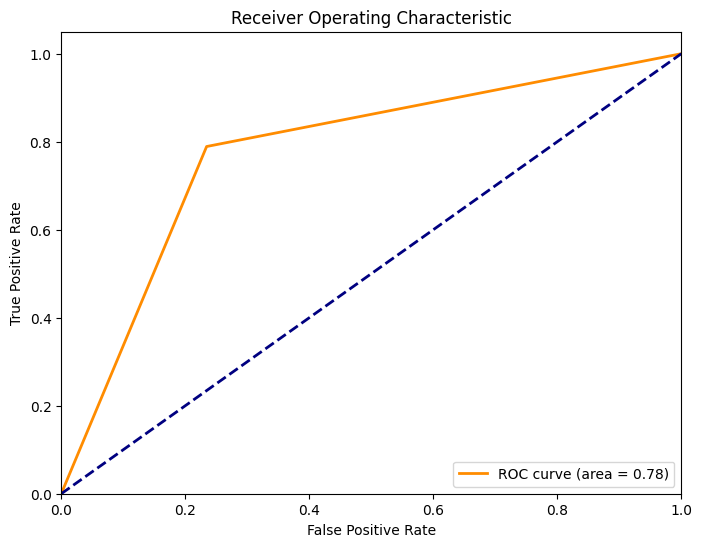

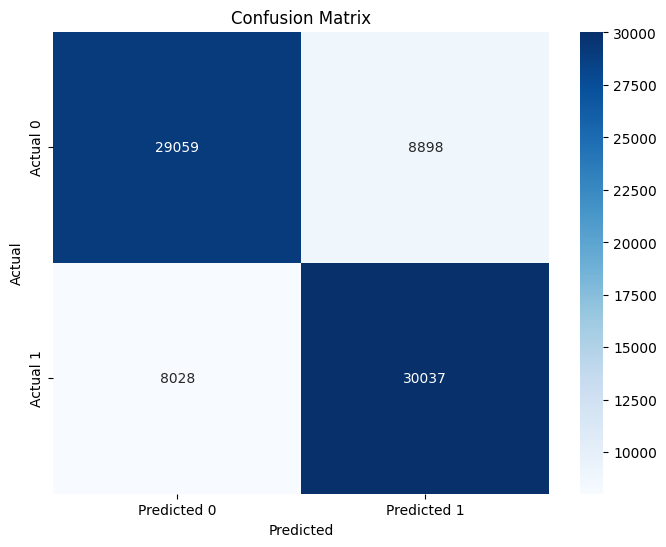

In [14]:
# prompt: plot evaluate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred are defined from the previous code

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:

import pandas as pd
importances = best_rf_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
0,HighBP,0.338537
1,HighChol,0.227274
13,GenHlth,0.172791
3,BMI,0.074218
18,Age,0.059689
7,PhysActivity,0.040071
19,Education,0.025988
15,PhysHlth,0.019245
20,Income,0.013850
17,Sex,0.011681


#Model Interpretability – LIME

In [16]:
# LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification'
)

In [17]:
# Explain a prediction
i = 0  # Choose an instance to explain
exp = explainer.explain_instance(X_test[i], grid_search.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

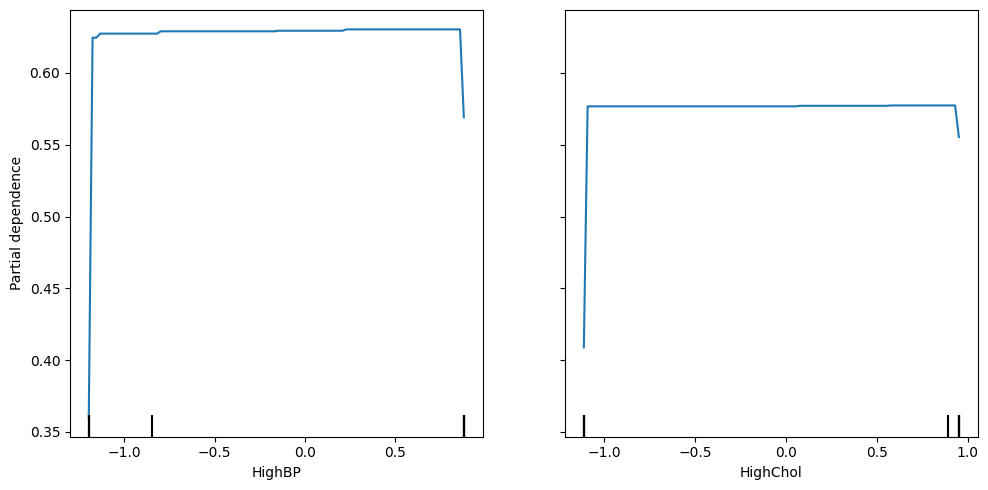

In [18]:
from sklearn.inspection import PartialDependenceDisplay

# Get list of feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"feature_{i}" for i in range(X.shape[1])]

# Choose 1 or more features for PDP — here we pick first two for demo
features_to_plot = [0, 1]  # or use ['age', 'BMI'] etc., if column names known

# Plot PDP
fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(best_rf_model, X_train, features_to_plot, feature_names=feature_names, ax=ax)
plt.tight_layout()
plt.show()

Fidelity (Accuracy vs RF predictions): 0.9050


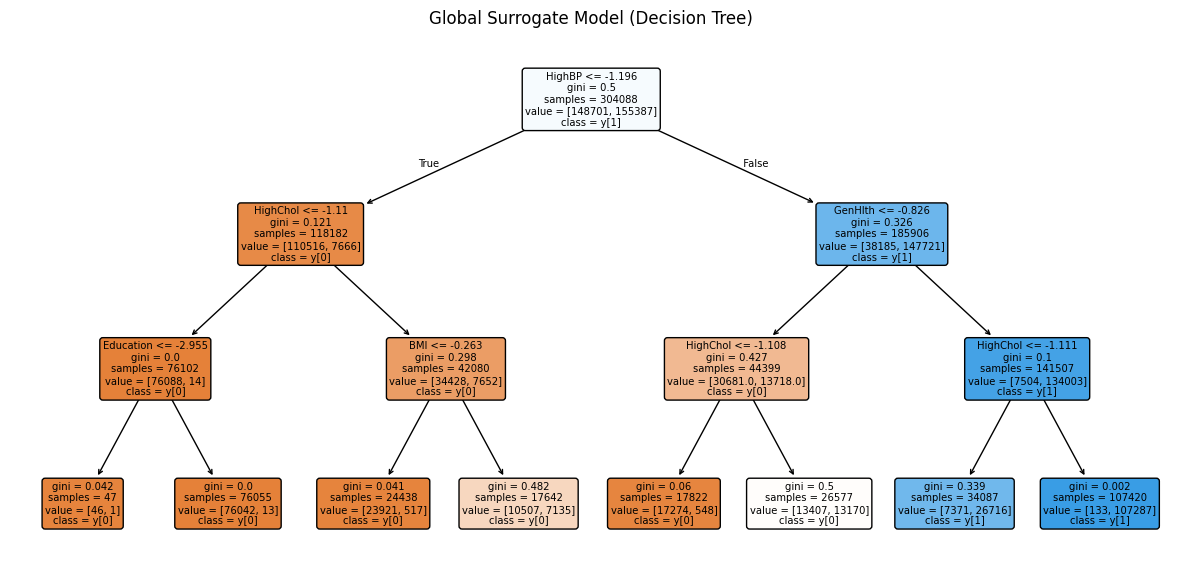

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

blackbox_preds = best_rf_model.predict(X_train)

surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, blackbox_preds)

surrogate_preds = surrogate.predict(X_train)
fidelity = accuracy_score(blackbox_preds, surrogate_preds)
print(f"Fidelity (Accuracy vs RF predictions): {fidelity:.4f}")

plt.figure(figsize=(15, 7))
plot_tree(surrogate, feature_names=X.columns, class_names=True, filled=True, rounded=True)
plt.title("Global Surrogate Model (Decision Tree)")
plt.show()
